In [1]:
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
import requests
import os
import pandas as pd

def download_xeno_canto(species, num_recordings=50, output_dir='data'):
    base_url = 'https://xeno-canto.org/api/2/recordings'
    
    os.makedirs(output_dir, exist_ok=True)
    
    params = {
        'query': species,
        'page': 1
    }
    
    recordings = []
    while len(recordings) < num_recordings:
        response = requests.get(base_url, params=params)
        data = response.json()
        
        for recording in data['recordings']:
            if len(recordings) >= num_recordings:
                break
            recordings.append(recording)
        
        params['page'] += 1
        if params['page'] > data['numPages']:
            break
    
    for i, recording in enumerate(recordings):
        file_url = recording['file']
        file_name = f"{species.replace(' ', '_')}_{i}.mp3"
        file_path = os.path.join(output_dir, file_name)
        
        response = requests.get(file_url)
        with open(file_path, 'wb') as f:
            f.write(response.content)
        
        print(f"Downloaded: {file_name}")

# Download recordings for each species
species_list = ['Brown Tinamou', 'Great Tinamou', 'Cinereous Tinamou']
for species in species_list:
    download_xeno_canto(species)

Downloaded: Brown_Tinamou_0.mp3
Downloaded: Brown_Tinamou_1.mp3
Downloaded: Brown_Tinamou_2.mp3
Downloaded: Brown_Tinamou_3.mp3
Downloaded: Brown_Tinamou_4.mp3
Downloaded: Brown_Tinamou_5.mp3
Downloaded: Brown_Tinamou_6.mp3
Downloaded: Brown_Tinamou_7.mp3
Downloaded: Brown_Tinamou_8.mp3
Downloaded: Brown_Tinamou_9.mp3
Downloaded: Brown_Tinamou_10.mp3
Downloaded: Brown_Tinamou_11.mp3
Downloaded: Brown_Tinamou_12.mp3
Downloaded: Brown_Tinamou_13.mp3
Downloaded: Brown_Tinamou_14.mp3
Downloaded: Brown_Tinamou_15.mp3
Downloaded: Brown_Tinamou_16.mp3
Downloaded: Brown_Tinamou_17.mp3
Downloaded: Brown_Tinamou_18.mp3
Downloaded: Brown_Tinamou_19.mp3
Downloaded: Brown_Tinamou_20.mp3
Downloaded: Brown_Tinamou_21.mp3
Downloaded: Brown_Tinamou_22.mp3
Downloaded: Brown_Tinamou_23.mp3
Downloaded: Brown_Tinamou_24.mp3
Downloaded: Brown_Tinamou_25.mp3
Downloaded: Brown_Tinamou_26.mp3
Downloaded: Brown_Tinamou_27.mp3
Downloaded: Brown_Tinamou_28.mp3
Downloaded: Brown_Tinamou_29.mp3
Downloaded: Brown_Ti

In [15]:
import os
import csv

def create_csv_from_downloaded_sounds(base_dir='data', csv_file_path='recordings_metadata.csv'):
    # Prepare the CSV header
    csv_columns = ['file_name', 'species']
    csv_rows = []

    # Traverse each species directory
    for species_dir in os.listdir(base_dir):
        species_path = os.path.join(base_dir, species_dir)
        if os.path.isdir(species_path):
            # Traverse each file in the species directory
            for file_name in os.listdir(species_path):
                if file_name.endswith('.mp3'):
                    # Assuming the file name format is "<species>_<index>.mp3"
                    file_path = os.path.join(species_path, file_name)
                    
                    # Collect metadata (modify this as needed based on your file naming and available metadata)
                    species = species_dir.replace('_', ' ')

                    csv_rows.append({
                        'file_name': file_name,
                        'species': species,
                    })

    # Write the collected metadata to the CSV file
    with open(csv_file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        writer.writerows(csv_rows)

    print(f"CSV file created at: {csv_file_path}")

# Run the function to create the CSV file
create_csv_from_downloaded_sounds()

CSV file created at: recordings_metadata.csv


In [3]:
import librosa
import soundfile as sf
import os
import numpy as np

def preprocess_audio(file_path, output_path, sample_rate=22050):
    y, sr = librosa.load(file_path, sr=sample_rate)
    y = librosa.util.fix_length(y, size=sample_rate * 30)
    sf.write(output_path, y, sample_rate)

def augment_audio(y, sample_rate):
    # Add Gaussian noise
    noise = np.random.randn(len(y))
    y_noise = y + 0.005 * noise
    # Time shifting
    shift = np.random.randint(sample_rate)
    y_shift = np.roll(y, shift)
    # Pitch shifting
    y_pitch = librosa.effects.pitch_shift(y, sr=sample_rate, n_steps=4)
    return [y_noise, y_shift, y_pitch]

species_list = ["Brown Tinamou", "Great Tinamou", "Cinereous Tinamou"]
data_dir = 'data'

# Create a 'processed' directory inside the 'data' directory
processed_dir = os.path.join(data_dir, 'processed')
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

for species in species_list:
    species_processed_dir = os.path.join(processed_dir, species.replace(' ', '_'))
    if not os.path.exists(species_processed_dir):
        os.makedirs(species_processed_dir)

    files = [f for f in os.listdir(data_dir) if f.startswith(species.replace(' ', '_')) and f.endswith('.mp3')]
    
    for file in files:
        # Convert to uniform format and sample rate
        input_file_path = os.path.join(data_dir, file)
        output_file_path = os.path.join(species_processed_dir, file.replace('.mp3', '.wav'))
        preprocess_audio(input_file_path, output_file_path)

        # Perform augmentation
        y, sr = librosa.load(output_file_path, sr=22050)
        augmented_samples = augment_audio(y, sr)

        # Save augmented samples
        for i, aug_sample in enumerate(augmented_samples):
            aug_file_path = os.path.join(species_processed_dir, f"{file.replace('.mp3', '')}_aug{i+1}.wav")
            sf.write(aug_file_path, aug_sample, sr)

print("Preprocessing and augmentation completed.")

Preprocessing and augmentation completed.


Processing Brown_Tinamou...


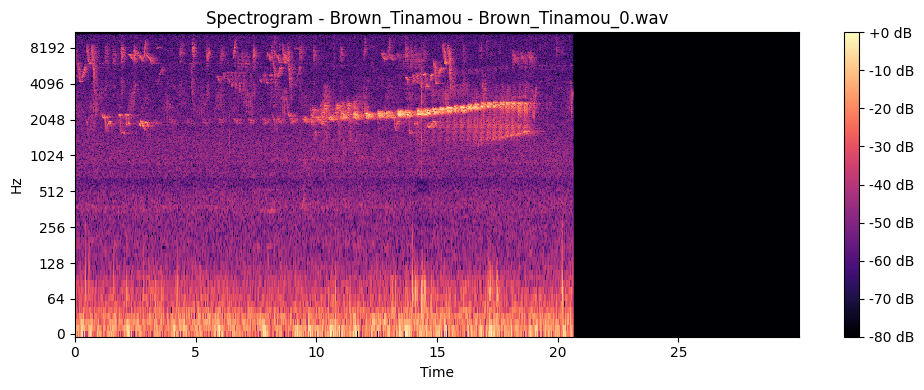

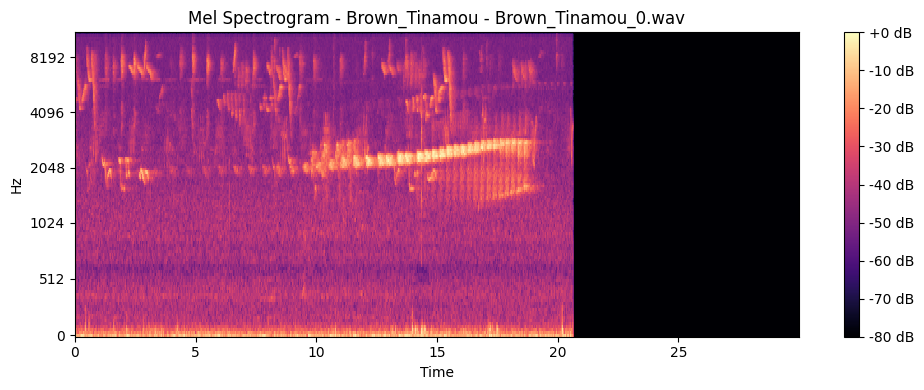

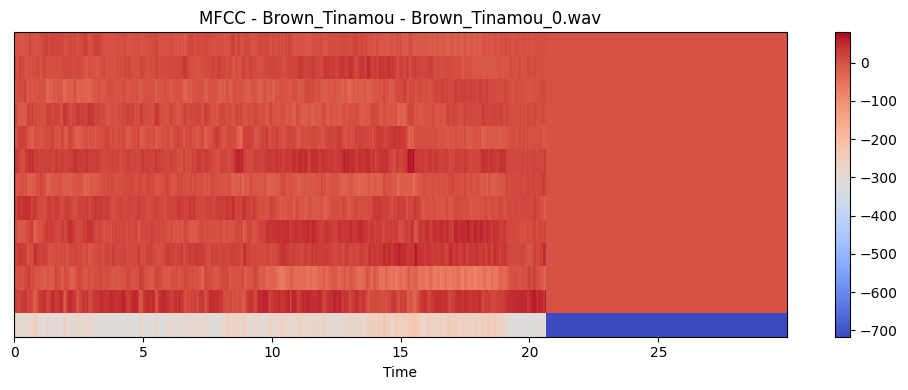

Processing Great_Tinamou...


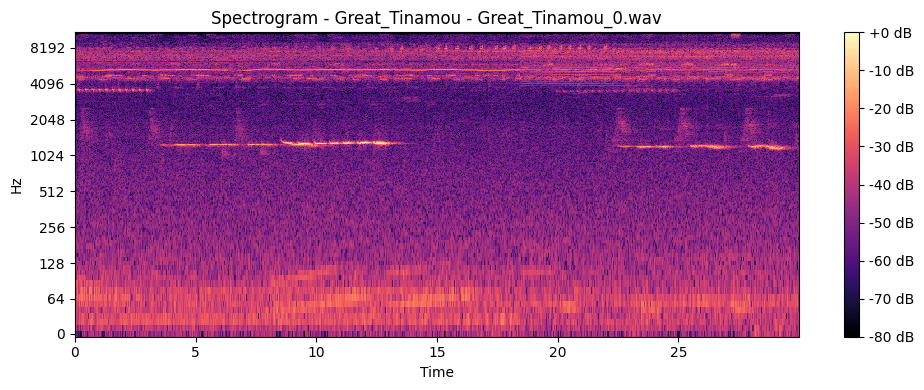

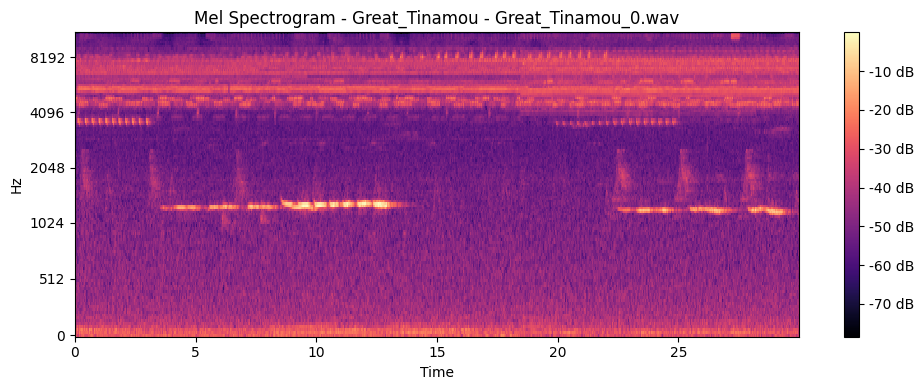

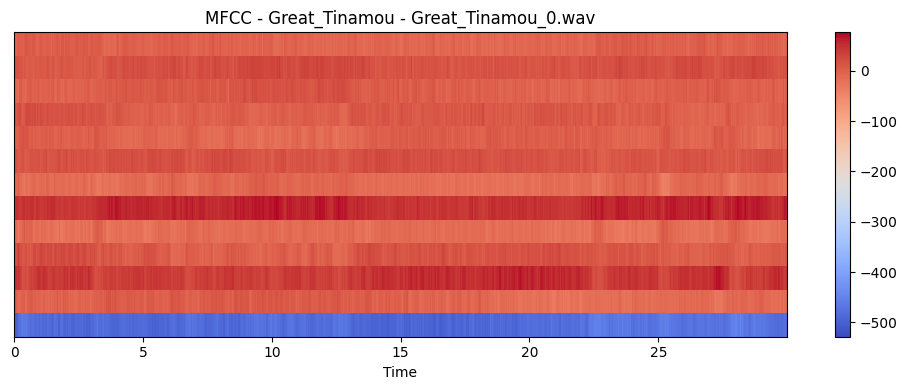

Processing Cinereous_Tinamou...


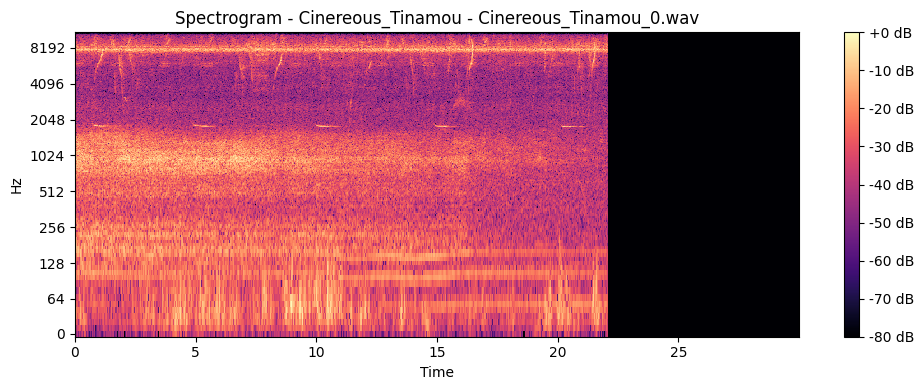

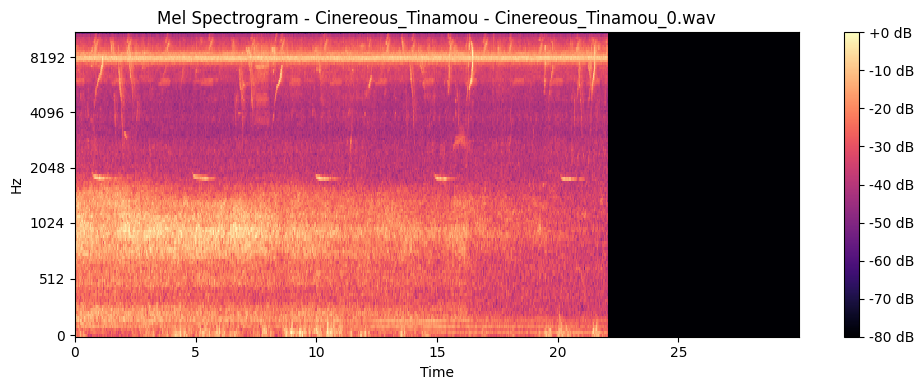

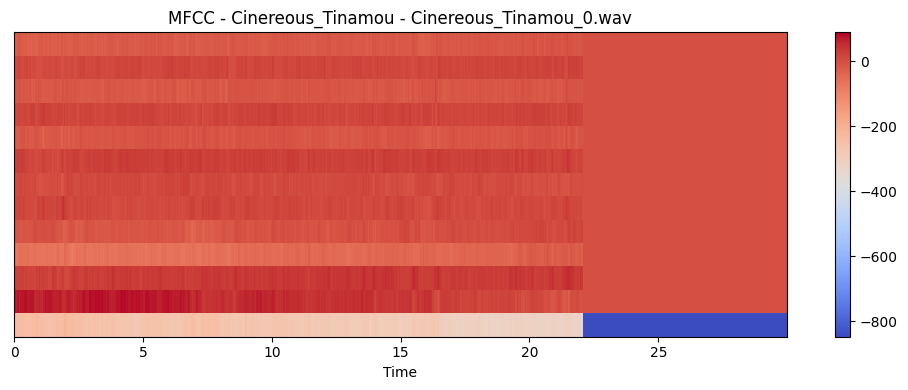

Feature extraction and plotting completed.


In [4]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def extract_spectrogram(y, sr):
    spectrogram = librosa.stft(y)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
    return spectrogram_db

def extract_mel_spectrogram(y, sr):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

def extract_mfcc(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfccs

def plot_features(y, sr, title):
    # Plot Spectrogram
    plt.figure(figsize=(10, 4))
    S = extract_spectrogram(y, sr)
    librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {title}')
    plt.tight_layout()
    plt.show()

    # Plot Mel Spectrogram
    plt.figure(figsize=(10, 4))
    S = extract_mel_spectrogram(y, sr)
    librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {title}')
    plt.tight_layout()
    plt.show()

    # Plot MFCC
    plt.figure(figsize=(10, 4))
    mfccs = extract_mfcc(y, sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC - {title}')
    plt.tight_layout()
    plt.show()

# Define the path to the processed data
processed_dir = 'data/processed'

# List of species
species_list = ['Brown_Tinamou', 'Great_Tinamou', 'Cinereous_Tinamou']

# Process one file from each species
for species in species_list:
    species_dir = os.path.join(processed_dir, species)
    if os.path.isdir(species_dir):
        print(f"Processing {species}...")
        
        # Get the first .wav file in the species directory
        wav_files = [f for f in os.listdir(species_dir) if f.endswith('.wav')]
        if wav_files:
            audio_file = wav_files[0]
            file_path = os.path.join(species_dir, audio_file)
            
            # Load the audio file
            y, sr = librosa.load(file_path, sr=None)
            
            # Extract and plot features
            plot_features(y, sr, f"{species} - {audio_file}")
        else:
            print(f"No .wav files found for {species}")

print("Feature extraction and plotting completed.")

In [5]:
import os
import numpy as np
import librosa

def extract_mfcc(y, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

def load_and_preprocess_dataset(species_list, processed_dir='data/processed'):
    X, y = [], []
    for i, species in enumerate(species_list):
        species_dir = os.path.join(processed_dir, species.replace(' ', '_'))
        if os.path.isdir(species_dir):
            files = os.listdir(species_dir)
            for file in files:
                if file.endswith(".wav"):
                    file_path = os.path.join(species_dir, file)
                    y_audio, sr = librosa.load(file_path, sr=22050)
                    mfccs = extract_mfcc(y_audio, sr)
                    X.append(mfccs)
                    y.append(i)
        else:
            print(f"Directory not found: {species_dir}")
    return np.array(X), np.array(y)

species_list = ["Brown Tinamou", "Great Tinamou", "Cinereous Tinamou"]
X, y = load_and_preprocess_dataset(species_list)

if len(X) > 0:
    print(f"Shape of MFCC features: {X[0].shape}")
    print(f"Total number of samples: {len(X)}")
    print(f"Number of samples for each class: {np.bincount(y)}")
else:
    print("No samples were processed. Check your directory structure and file names.")
    exit()

Shape of MFCC features: (13, 1292)
Total number of samples: 600
Number of samples for each class: [200 200 200]


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models

# Expand dimensions to match CNN input requirements (channels last)
X = np.expand_dims(X, -1)

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Verify the shapes
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Check the shape of MFCC features
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(f"Input shape: {input_shape}")

Shape of X_train: (420, 13, 1292, 1)
Shape of X_val: (90, 13, 1292, 1)
Shape of X_test: (90, 13, 1292, 1)
Input shape: (13, 1292, 1)


In [7]:
# Define the model with adjusted architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
14/14 [==============================] - 10s 717ms/step - loss: 0.0555 - accuracy: 0.9810 - val_loss: 0.2959 - val_accuracy: 0.9222
Epoch 2/20
14/14 [==============================] - 10s 698ms/step - loss: 0.0642 - accuracy: 0.9762 - val_loss: 0.1854 - val_accuracy: 0.9111
Epoch 3/20
14/14 [==============================] - 10s 698ms/step - loss: 0.0364 - accuracy: 0.9929 - val_loss: 0.2591 - val_accuracy: 0.8889
Epoch 4/20
14/14 [==============================] - 9s 669ms/step - loss: 0.0553 - accuracy: 0.9786 - val_loss: 0.2032 - val_accuracy: 0.9111
Epoch 5/20
14/14 [==============================] - 8s 590ms/step - loss: 0.0380 - accuracy: 0.9881 - val_loss: 0.1776 - val_accuracy: 0.9556
Epoch 6/20
14/14 [==============================] - 9s 627ms/step - loss: 0.0310 - accuracy: 0.9905 - val_loss: 0.1668 - val_accuracy: 0.9222
Epoch 7/20
14/14 [==============================] - 9s 614ms/step - loss: 0.0182 - accuracy: 0.9976 - val_loss: 0.2309 - val_accuracy: 0.9222
Epo

In [13]:
# Save the model to an H5 file
model.save('Bird_Species_Identification.h5')

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Calculate additional metrics
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=species_list))

3/3 - 0s - loss: 0.9318 - accuracy: 0.8556 - 494ms/epoch - 165ms/step
Test accuracy: 0.855555534362793
3/3 [==============================] - 0s 150ms/step
                   precision    recall  f1-score   support

    Brown Tinamou       1.00      0.89      0.94        38
    Great Tinamou       0.76      0.88      0.81        25
Cinereous Tinamou       0.78      0.78      0.78        27

         accuracy                           0.86        90
        macro avg       0.85      0.85      0.85        90
     weighted avg       0.87      0.86      0.86        90



In [33]:
import tensorflow as tf
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the trained model
model = tf.keras.models.load_model('Bird_Species_Identification.h5')

# Mapping of predicted class index to bird species names
bird_species = {
    0: "Brown Tinamou",
    1: "Great Tinamou",
    2: "Cinereous Tinamou"
}

def preprocess_user_audio(file_path, sample_rate=22050, n_mfcc=13, max_pad_len=1292):
    y, sr = librosa.load(file_path, sr=sample_rate)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Transpose the MFCCs matrix to match the expected shape
    mfccs = mfccs.T
    
    # Padding or truncating the MFCCs to ensure consistent shape
    if mfccs.shape[0] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[0]
        mfccs = np.pad(mfccs, pad_width=((0, pad_width), (0, 0)), mode='constant')
    else:
        mfccs = mfccs[:max_pad_len]
    
    # Add the channel dimension
    mfccs = np.expand_dims(mfccs, -1)
    
    # Ensure the final shape matches (None, 13, 1292, 1)
    mfccs = np.transpose(mfccs, (1, 0, 2))
    
    return mfccs

def get_prediction(file_path):
    # Preprocess the sound file
    mfccs = preprocess_user_audio(file_path)
    
    # Normalize the features using the same scaler used during training
    scaler = StandardScaler()
    mfccs = scaler.fit_transform(mfccs.reshape(-1, mfccs.shape[-1])).reshape(mfccs.shape)
    
    # Add batch dimension
    mfccs = np.expand_dims(mfccs, axis=0)
    
    # Predict the bird species
    prediction = model.predict(mfccs)
    
    # Get the index of the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    
    # Map the index to the bird species name
    predicted_species = bird_species[predicted_class[0]]
    
    return predicted_species

# Example usage
file_path = "./data/Cinereous_Tinamou_12.mp3"
predicted_species = get_prediction(file_path)
print(f"Predicted species: {predicted_species}")

1/1 [==============================] - 0s 176ms/step
Predicted species: Brown Tinamou
